In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle

import cell_order_log_analysis
import sys
sys.path.append('../radio_api')
import constants

In [2]:
FIG_SIZE = (8,5)
FONT_SIZE = 16
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 3.5
SAVE_FIG = False

RESERVATION = 'RES130780'
exp_idx = '13min'
reservation_data_dir = '../data/' + RESERVATION + '/'
cell_order_log_filename = reservation_data_dir + 'cell-order-changingBudgets-lat-{}.log'.format(exp_idx)
cell_order_ue_log_filename = reservation_data_dir + 'cell-order-ue2-changingBudgets-lat-{}.log'.format(exp_idx)

if (SAVE_FIG):
    reservation_out_dir = '../outputs/' + RESERVATION + '/'
    if (not os.path.exists(reservation_out_dir)):
        os.mkdir(reservation_out_dir)

SLA_PERIOD = 30 # seconds over which the SLAs are negotiated
OUTLIER_PERCENTILE = 5 # Percentile to clip-off from both ends for each SLA period

In [3]:
bs_data, budgets, ts_start = cell_order_log_analysis.read_cell_order_log(cell_order_log_filename)
cell_order_log_analysis.summarize_over_sla_period(bs_data, SLA_PERIOD, OUTLIER_PERCENTILE)

cur_data, slice_id, _ = cell_order_log_analysis.read_cell_order_ue_log(cell_order_ue_log_filename, ts_start)
ue_data = {slice_id: cur_data}

active_slice = list(ue_data.keys())[0]
assert active_slice in bs_data.keys()

Data for 758.353000164032 seconds has been extracted
UE Data for 754.8280000686646 seconds has been extracted


In [4]:
for user_id, supply_times in budgets['supply_times'].items():
    port_offset = int(user_id[0].split('.')[-1])
    sid = port_offset % constants.SLICE_NUM
    
    bs_data[sid]['filtered_ts_sec'] = []
    bs_data[sid]['filtered_lat_msec'] = []
    for supply_time in supply_times:
        supply_time -= ts_start
        ts_filter = np.logical_and(bs_data[sid]['raw_ts_sec'] >= supply_time,
                                   bs_data[sid]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
        if (not ts_filter.any()):
            continue
        sla_ts_sec = bs_data[sid]['raw_ts_sec'][ts_filter]
        sla_lat_msec = bs_data[sid]['raw_lat_msec'][ts_filter]

        outlier_filter = np.logical_and(sla_lat_msec <= np.percentile(sla_lat_msec, 100 - OUTLIER_PERCENTILE),
                                        sla_lat_msec >= np.percentile(sla_lat_msec, OUTLIER_PERCENTILE))
        if (outlier_filter.any()):
            bs_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))
            bs_data[sid]['filtered_lat_msec'].append(np.mean(sla_lat_msec[outlier_filter]))
        else:
            bs_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))
            bs_data[sid]['filtered_lat_msec'].append(np.median(sla_lat_msec))

    bs_data[sid]['filtered_ts_sec'] = np.array(bs_data[sid]['filtered_ts_sec'])
    bs_data[sid]['filtered_lat_msec'] = np.array(bs_data[sid]['filtered_lat_msec'])

In [5]:
ue_data[active_slice]['filtered_ts_sec'] = []
ue_data[active_slice]['filtered_rtt_msec'] = []
for supply_time in ue_data[active_slice]['supply_times']:
    ts_filter = np.logical_and(ue_data[active_slice]['raw_ts_sec'] >= supply_time,
                               ue_data[active_slice]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
    if (not ts_filter.any()):
        continue
    sla_ts_sec = ue_data[active_slice]['raw_ts_sec'][ts_filter]
    sla_rtt_msec = ue_data[active_slice]['raw_rtt_msec'][ts_filter]

    outlier_filter = np.logical_and(sla_rtt_msec <= np.percentile(sla_rtt_msec, 100 - OUTLIER_PERCENTILE),
                                    sla_rtt_msec >= np.percentile(sla_rtt_msec, OUTLIER_PERCENTILE))
    if (outlier_filter.any()):
        ue_data[active_slice]['filtered_ts_sec'].append(np.max(sla_ts_sec))
        ue_data[active_slice]['filtered_rtt_msec'].append(np.mean(sla_rtt_msec[outlier_filter]))
    else:
        ue_data[active_slice]['filtered_ts_sec'].append(np.max(sla_ts_sec))
        ue_data[active_slice]['filtered_rtt_msec'].append(np.median(sla_rtt_msec))

ue_data[active_slice]['filtered_ts_sec'] = np.array(ue_data[active_slice]['filtered_ts_sec'])
ue_data[active_slice]['filtered_rtt_msec'] = np.array(ue_data[active_slice]['filtered_rtt_msec'])

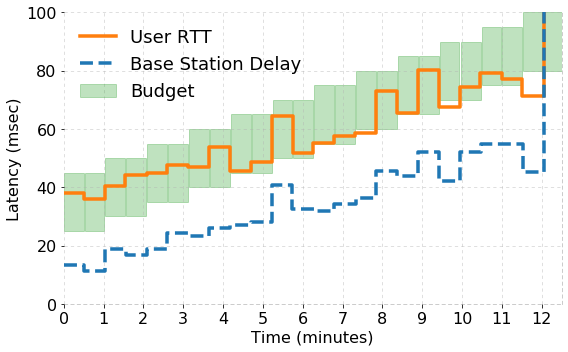

In [6]:
plt.figure(figsize = FIG_SIZE)

plt.step(np.insert(ue_data[active_slice]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(ue_data[active_slice]['filtered_rtt_msec'], 0, ue_data[active_slice]['filtered_rtt_msec'][0]), 
         where='pre', label='User RTT', linewidth=3.5, color='C1')
plt.step(np.insert(bs_data[active_slice]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['filtered_lat_msec'], 0, bs_data[active_slice]['filtered_lat_msec'][0]), 
         where='pre', label='Base Station Delay', linewidth=3.5, color='C0', linestyle='--')

cnt = 1
min_budget = 20
for supply_time in budgets['supply_times'][user_id]:
    ts_minutes = (supply_time - ts_start) / 60
    min_budget += (cnt % 2) * 5
    if (cnt == 1):
        plt.gca().add_patch(Rectangle((ts_minutes, min_budget), SLA_PERIOD / 60, 20, color='C2', alpha=0.3, label='Budget'))
    else:
        plt.gca().add_patch(Rectangle((ts_minutes, min_budget), SLA_PERIOD / 60, 20, color='C2', alpha=0.3))
    cnt += 1

plt.gca().set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
plt.gca().set_ylabel('Latency (msec)', fontsize=FONT_SIZE)
plt.gca().tick_params(axis='y', labelsize=FONT_SIZE)
plt.gca().tick_params(axis='x', labelsize=FONT_SIZE)
plt.gca().set_ylim((0, 100))
plt.gca().set_xlim([0,12.5])
plt.gca().xaxis.set_ticks(np.arange(0, 13))

plt.gca().legend(loc='upper left', frameon=False, fontsize=FONT_SIZE+2)

plt.gca().grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_linestyle(LINE_STYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')

plt.tight_layout()  # otherwise the right y-label is slightly clipped

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'provider_vs_user_lat.pdf')

plt.show()

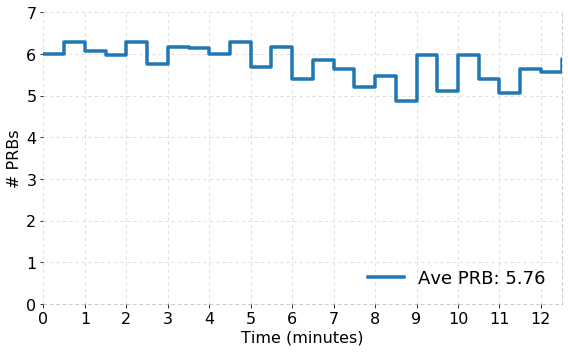

In [7]:
plt.figure(figsize = FIG_SIZE)

plt.step(np.insert(bs_data[active_slice]['ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['n_rbgs'], 0, bs_data[active_slice]['n_rbgs'][0]), 
         label='Ave PRB: {:.2f}'.format(np.mean(bs_data[active_slice]['raw_n_rbgs'])), 
         where='pre', linewidth=3.5, color='C0', linestyle='-')

plt.gca().set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
plt.gca().set_ylabel('# PRBs', fontsize=FONT_SIZE)
plt.gca().tick_params(axis='y', labelsize=FONT_SIZE)
plt.gca().tick_params(axis='x', labelsize=FONT_SIZE)
plt.gca().set_ylim((0, 7))
plt.gca().set_xlim([0, 12.5])
plt.gca().xaxis.set_ticks(np.arange(13))

plt.gca().legend(loc='lower right', frameon=False, fontsize=FONT_SIZE+2)

plt.gca().grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_linestyle(LINE_STYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')

plt.tight_layout()  # otherwise the right y-label is slightly clipped

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'prb.pdf')

plt.show()

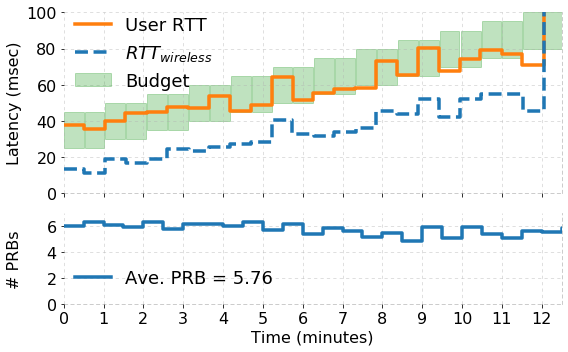

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=FIG_SIZE)

ax1.step(np.insert(ue_data[active_slice]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(ue_data[active_slice]['filtered_rtt_msec'], 0, ue_data[active_slice]['filtered_rtt_msec'][0]), 
         where='pre', label='User RTT', linewidth=3.5, color='C1')
ax1.step(np.insert(bs_data[active_slice]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['filtered_lat_msec'], 0, bs_data[active_slice]['filtered_lat_msec'][0]), 
         where='pre', label='$RTT_{wireless}$', linewidth=3.5, color='C0', linestyle='--')

cnt = 1
min_budget = 20
for supply_time in budgets['supply_times'][user_id]:
    ts_minutes = (supply_time - ts_start) / 60
    min_budget += (cnt % 2) * 5
    if (cnt == 1):
        ax1.add_patch(Rectangle((ts_minutes, min_budget), SLA_PERIOD / 60, 20, color='C2', alpha=0.3, label='Budget'))
    else:
        ax1.add_patch(Rectangle((ts_minutes, min_budget), SLA_PERIOD / 60, 20, color='C2', alpha=0.3))
    cnt += 1

# ax1.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax1.set_ylabel('Latency (msec)', fontsize=FONT_SIZE)
ax1.tick_params(axis='y', labelsize=FONT_SIZE)
# ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.get_xaxis().set_ticklabels([])
ax1.set_ylim((0, 100))
ax1.set_xlim([0,12.5])
ax1.xaxis.set_ticks(np.arange(0, 13))

ax1.legend(loc='upper left', frameon=False, fontsize=FONT_SIZE+2,
           bbox_to_anchor=[-0.01,1.07])

ax1.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax1.spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

ax2.step(np.insert(bs_data[active_slice]['ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['n_rbgs'], 0, bs_data[active_slice]['n_rbgs'][0]), 
         label='Ave. PRB = {:.2f}'.format(np.mean(bs_data[active_slice]['raw_n_rbgs'])), 
         where='pre', linewidth=3.5, color='C0', linestyle='-')

ax2.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax2.set_ylabel('# PRBs', fontsize=FONT_SIZE)
ax2.tick_params(axis='y', labelsize=FONT_SIZE)
ax2.tick_params(axis='x', labelsize=FONT_SIZE)
ax2.set_ylim((0, 7))
ax2.yaxis.set_ticks(np.arange(0,8,2))
ax2.set_xlim([0, 12.5])
ax2.xaxis.set_ticks(np.arange(13))

ax2.legend(loc='lower left', frameon=False, fontsize=FONT_SIZE+2,
           bbox_to_anchor=[-0.01,0.0])

ax2.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax2.spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

f.tight_layout()  
f.align_ylabels()

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'provider_vs_user_lat_and_prb.pdf')

plt.show()